# EDS232 Lab 2: Regularized Regression


## Overview
In this lab, you will explore Ridge Regression and Lasso Regression, two common techniques for regularized regression. Both methods add penalties to the regression coefficients, which can help prevent overfitting and improve model interpretability. We will also apply the one-standard-error rule for Lasso regression to select a simpler model.

## Objectives
By the end of this lab, you will:
- Implement Ridge and Lasso regression with cross-validation.
- Compare the performance of Ridge and Lasso models.
- Interpret model coefficients and understand their regularization effects.
- Apply the one-standard-error rule to select a parsimonious Lasso model.

## Key Concepts

**What is Regularized Regression?**
- Regularized regression techniques are used to improve model generalization and prevent overfitting by adding a penalty term to the loss function of linear regression.
- These methods are particularly useful for datasets with:
    - A large number of predictors.
    - High multicollinearity among predictors.
    - A tendency to overfit due to a small number of observations.

**Types of Regularization:**

- Ridge Regression:

    - Adds an L2 penalty ($\lambda \sum_{j=1}^p \beta_j^2 $) to the regression loss function.
    - Shrinks coefficients toward zero but does not set any coefficients exactly to zero.
    - Best suited for reducing multicollinearity and improving model stability.

- Lasso Regression:

    - Adds an L1 penalty ($\lambda \sum_{j=1}^p |\beta_j|$) to the regression loss function.
    - Can shrink some coefficients to exactly zero, effectively performing feature selection.
    - Useful when you want a simpler, interpretable model.




#### About the data

- We will be working with data dealing with physical abalone features. This dataset has observations of more than 4,000 abalone, measuring their length, diameter, height, and different rings. The data can be found here : https://archive.ics.uci.edu/dataset/1/abalone. 


- Notice that the data is not a csv file and is instead a .data file! The .data file does not contain any column names, so we therefore need to specify the column names when we read our data in using `pd.read_csv`. Look at the metadata and assign column names to the data. When you are finished, look at the head of the dataframe to ensure it looks correct. 


In [86]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression 
from ucimlrepo import fetch_ucirepo
import kagglehub


In [76]:
# Fetch dataset
energy_efficiency = fetch_ucirepo(id=242)


### Explore the data

Data Splitting
Question 1: Split the data into training and test sets using a 70/30 split.

In [79]:
# Assign predictor and outcome variables 
X = energy_efficiency.data.features
Y = energy_efficiency.data.targets['Y1']
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)


Ridge Regression
Question 2 & 3: Fit a ridge regression model and visualize how coefficients change with lambda.

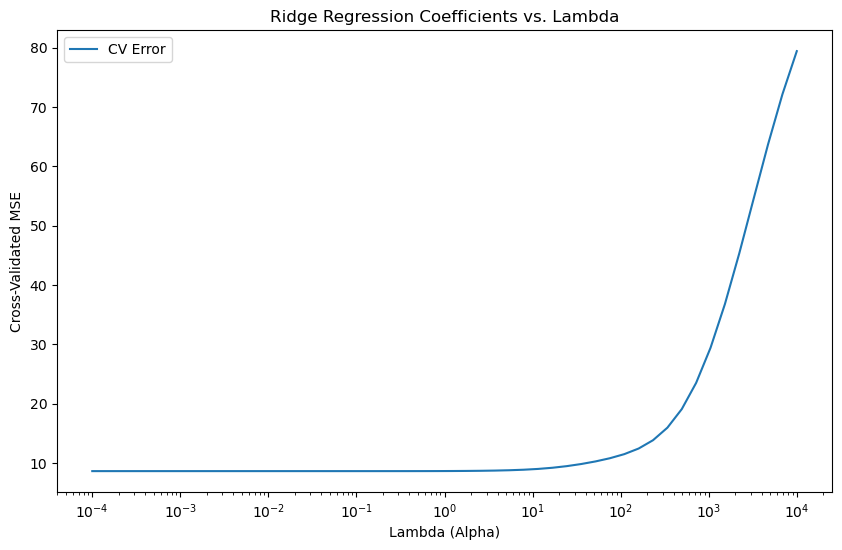

In [80]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV

# Standardize the predictors
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Ridge regression with varying alphas
alphas = np.logspace(-4, 4, 50) # reduced alphas for run time for time being
ridge = RidgeCV(alphas=alphas,  store_cv_results=True) # removing cv = , can't have both cv = and store_cv_results = True

ridge.fit(X_train_scaled, y_train)

# Coefficients plot
plt.figure(figsize=(10, 6))
plt.plot(ridge.alphas, ridge.cv_results_.mean(axis=0).flatten(), label="CV Error") # flattened cv results and updated to cv_results_ instead of cv_values_
plt.xscale("log")
plt.xlabel("Lambda (Alpha)")
plt.ylabel("Cross-Validated MSE")
plt.title("Ridge Regression Coefficients vs. Lambda")
plt.legend()
plt.show()


Lasso Regression and Cross Validation
Question 4 & 5: Fit lasso regression using LassoCV and interpret the results.

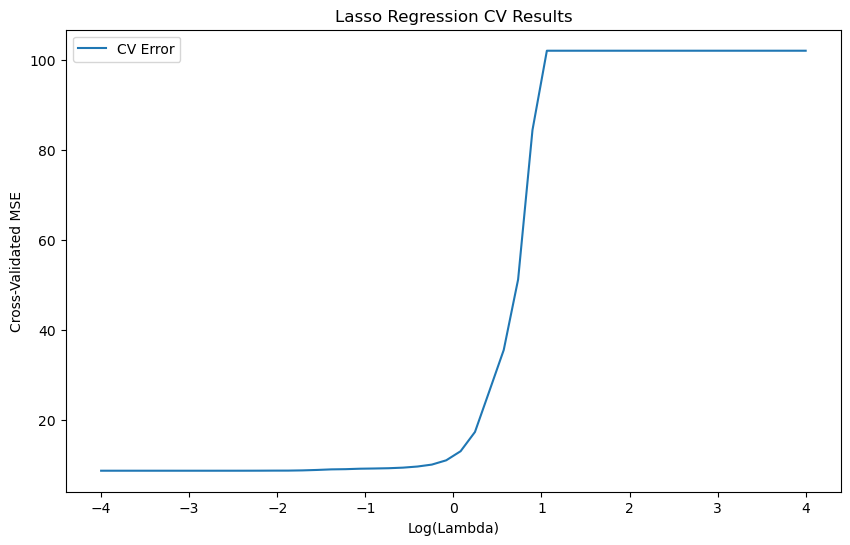

In [83]:
from sklearn.linear_model import LassoCV

# Lasso regression with cross-validation
lasso = LassoCV(alphas=alphas, cv=10, random_state=42)
lasso.fit(X_train_scaled,y_train.values.ravel()) # included .ravel to make 1D to avoid warning message 

# Plot Lasso results
plt.figure(figsize=(10, 6))
plt.plot(np.log10(lasso.alphas_), lasso.mse_path_.mean(axis=1), label="CV Error")
plt.xlabel("Log(Lambda)")
plt.ylabel("Cross-Validated MSE")
plt.title("Lasso Regression CV Results")
plt.legend()
plt.show()


Tuning and Model Comparison
Question 6 & 7: Find the minimum MSE and associated lambda for both Ridge and Lass

In [84]:
# Ridge results
ridge_min_mse = ridge.cv_results_.min() # changing cv_values_ to cv_results
ridge_best_alpha = ridge.alpha_

# Lasso results
lasso_min_mse = lasso.mse_path_.min()
lasso_best_alpha = lasso.alpha_

print(f"Ridge - Minimum MSE: {ridge_min_mse}, Best Alpha: {ridge_best_alpha}")
print(f"Lasso - Minimum MSE: {lasso_min_mse}, Best Alpha: {lasso_best_alpha}")


Ridge - Minimum MSE: 3.6275260288369897e-10, Best Alpha: 0.12648552168552957
Lasso - Minimum MSE: 4.461505176426431, Best Alpha: 0.0013894954943731374


Question 8: Use the "one-standard-error" rule and find the number of predictors in the Lasso model.

In [85]:
# One-standard-error rule for Lasso
lasso_best_alpha_1se = lasso.alphas_[np.where(
    lasso.mse_path_.mean(axis=1) <= (lasso.mse_path_.mean(axis=1).min() + lasso.mse_path_.std(axis=1).mean())
)[0][0]]

lasso_1se_model = Lasso(alpha=lasso_best_alpha_1se)
lasso_1se_model.fit(X_train_scaled, y_train)

print(f"Lasso 1-SE Rule Alpha: {lasso_best_alpha_1se}")
print(f"Number of Predictors in Lasso (1-SE): {np.sum(lasso_1se_model.coef_ != 0)}")


Lasso 1-SE Rule Alpha: 1.2067926406393288
Number of Predictors in Lasso (1-SE): 3


Question 9: Compare the performance of your Ridge and Lasso models.